## WeRateDogs, Udacity Project: Data Wrangling & Analyzing from Twitter

By Mohamed Hassan

### Introduction

<p align="justify"> This project focused on wrangling data from the WeRateDogs Twitter account using Python, documented in a Jupyter Notebook (wrangle_act.ipynb). This Twitter account rates dogs with humorous commentary. The rating denominator is usually 10, however, the numerators are usually greater than 10. They’re Good Dogs Brent wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. WeRateDogs has over 4 million followers and has received international media coverage.</p>

<p align="justify"> WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. </p>

<p align="justify"> The goal of this project is to wrangle the WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. I needed to gather, asses and clean the Twitter data for a worthy analysis and visualization.</p>

### Project Details

<p align="justify"> Fully assessing and cleaning the entire dataset would require exceptional effort so only a subset of its issues (eight quality issues and two tidiness issues at minimum) needed to be assessed and cleaned.</p>

**The tasks for this project were:**

Data wrangling, which consists of:

- Gathering data
- Assessing data
- Cleaning data
- Storing, analyzing, and visualizing our wrangled data Reporting on:

    (1) our data wrangling efforts and 
    
    (2) our data analyses and visualizations

### Key Points

**Key points to keep in mind when data wrangling for this project:**

- <p align="justify"> We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.</p>

- <p align="justify"> Fully assessing and cleaning the entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.</p>

- <p align="justify"> Cleaning includes merging individual pieces of data according to the rules of tidy data.</p>

- <p align="justify"> The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.</p>

- <p align="justify"> We do not need to gather the tweets beyond August 1st, 2017. We can, but note that we won't be able to gather the image predictions for these tweets since we don't have access to the algorithm used.</p>


In [1]:
# Import the libraries that we will need in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import requests
import tweepy
import time
from tweepy import OAuthHandler
from timeit import default_timer as timer
from datetime import datetime
from functools import reduce
% matplotlib inline

### <span style="color:red">Gather Data</span>

**1- Twitter Archive (Local File)**

Gather data from file on hand

In [2]:
# Read the twitter-archive-enhanced.csv file and store it as dataframe in archive
archive = pd.read_csv('twitter-archive-enhanced.csv', encoding = 'utf-8')
# Quick check to the file content and structure
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**The file twitter-archive-enhanced.csv successfully stored in archive data frame, it has 17 columns and 2356 entries** 

**2-Image Predictions (URL)**

Download file using Requests library and URL

In [4]:
# Using Requests library to download a file then store it in a tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

# Read the downloaded file into a dataframe 'images'
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')
# Quick check to the file content and structure
image_predictions.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**3-Tweets (Twitter API)**

Gather data from twitter API using Python's Tweepy library and store data

I tried to set up a twitter developer account, but my application was **not approved**.

- The following code is the Twitter API code supported by Udacity.
- So, I will comment it as a matter of reproducibilty when rerun all the code cells in this Jupyter notebook.


In [6]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)


# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor

# Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = twitter_archive.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [7]:
# read the file in DataFrame
with open('tweet-json.txt', 'r') as file:
    tweet_data = pd.read_json(file, lines= True, encoding = 'utf-8')

# check the data
tweet_data.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [8]:
# check for the columns names 
tweet_data.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [9]:
# select the columns of interest : 'id', 'favorite_count','retweet_count'
tweet_data = tweet_data.loc[:,['id','favorite_count','retweet_count']]

# check for the top 5 rows
tweet_data.head(5)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [10]:
#req. copies
archive_copy = archive.copy()
image_predictions_copy= image_predictions.copy()
tweet_data_copy = tweet_data.copy()


### Gather: Summary

Gathering is the first step in the data wrangling process.

-- Obtaining data
- Getting data from an existing file (twitter-archive-enhanced.csv) Reading from csv file using pandas
- Downloading a file from the internet (image-predictions.tsv) Downloading file using requests
- Querying an API (tweet_json.txt) Get JSON object of all the tweet_ids using Tweepy,but the Twitter API code I used that provided by Udacity.

-- Importing that data into our programming environment (Jupyter Notebook)



### <span style="color:red">Assessing Data</span>

- So, Now we have Three datasets archive_copy ,image_predictions_copy and tweet_data_copy
- First let's display one by one for visual assessing


In [11]:
# display archive_copy
archive_copy.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [12]:
# display image_pred
image_predictions_copy.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [13]:
# display tweet_data_copy
tweet_data_copy.head(3)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328


**More deep**

- Let's dive in deeper
- Assessing of the data programmatically



In [14]:
# archive_copy data info
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
# statistic description of archive_copy
archive_copy.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
# data sample 
archive_copy.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
11,889880896479866881,NaN,NaN,2017-07-25 16:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889880896...,13,10,Bruno,None,None,None,None
234,847617282490613760,8.476062e+17,4.196984e+09,2017-03-31 01:11:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",.@breaannanicolee PUPDATE: Cannon has a heart ...,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
957,751538714308972544,NaN,NaN,2016-07-08 22:09:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Max. She has one ear that's always sli...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751538714...,10,10,Max,None,None,None,None
362,829449946868879360,NaN,NaN,2017-02-08 22:00:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a stressed doggo. Had a long day. Many ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/829449946...,11,10,None,doggo,None,None,None
264,842163532590374912,NaN,NaN,2017-03-16 00:00:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet George. He looks slightly deflated but ov...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/842163532...,12,10,George,None,None,None,None


In [17]:
# check for source column
archive_copy.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
# check for the dog's name written style
archive_copy.name.str.istitle().value_counts()

True     2241
False     115
Name: name, dtype: int64

In [19]:
# check for those written as lowercase
lowers = archive_copy.name.loc[archive_copy.name.str.islower()].unique()
lowers

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [20]:
# check for the unique values of those non titled
untitled = archive_copy.name.loc[archive_copy.name.str.istitle() == False].unique()
untitled

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'BeBe', 'mad',
       'an', 'very', 'just', 'DonDon', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'CeCe', 'the',
       'by', 'officially', 'life', 'light', 'space', 'JD', 'DayZ'],
      dtype=object)

In [21]:
# check for those mis-written 
untitled_unlowers = [i for i in untitled if  i not in lowers]  
untitled_unlowers

['BeBe', 'DonDon', 'CeCe', 'JD', 'DayZ']

In [22]:
archive_copy['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
# Make sure numerators are consistent.
archive_copy.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [24]:
# Check for any numerators that equal zero.
archive_copy[archive_copy.rating_numerator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [25]:
archive_copy['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [26]:
# Make sure denominators are consistent
archive_copy.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [27]:
# Check for any denominators that equal zero.
archive_copy[archive_copy.rating_denominator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [28]:
# Detect entries where there are more than one dog stage.
archive_copy.loc[(archive_copy[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


In [29]:
archive_copy['name'].value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
the            8
Toby           7
Buddy          7
an             7
Bailey         7
Daisy          7
Milo           6
Stanley        6
Dave           6
Jack           6
Rusty          6
Jax            6
Koda           6
Bella          6
Oscar          6
Scout          6
Leo            6
George         5
            ... 
Derby          1
Angel          1
Covach         1
Eriq           1
Cuddles        1
Lacy           1
Kathmandu      1
Daniel         1
Kawhi          1
Pupcasso       1
Vixen          1
Colin          1
Jaspers        1
Nida           1
Wafer          1
Taz            1
Jazzy          1
Toffee         1
Simba          1
Danny          1
Aqua           1
Furzey         1
Sobe           1
Major          1
Augie          1
Marvin         1
Cupid          1
Rose          

In [30]:
# See if there are any dupulicates in the data frame.
sum(archive_copy.duplicated())


0

In [31]:
# image_predictions data info 
image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
# statistic description of image_predictions
image_predictions_copy.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [33]:
image_predictions_copy['jpg_url'].value_counts()

https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg                                            2
https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg                                            2
https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg                                            2
https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg                                            2
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                            2
https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg                                            2
https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg                                            2
https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg                                            2
https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg                                            2
https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg                                            2
https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg                       

In [34]:
# See if there are any duplicates in the data frame.
sum(image_predictions_copy.duplicated())

0

In [35]:
# tweet_data_copy data info 
tweet_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [36]:
# statistic description of tweet_data_copy
tweet_data_copy.describe()

,id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [37]:
# Check if there are any favorite entries that equal zero.
tweet_data_copy[tweet_data_copy['favorite_count'] == 0]

,id,favorite_count,retweet_count
31,886054160059072513,0,108
35,885311592912609280,0,19297
67,879130579576475649,0,7181
72,878404777348136964,0,1349
73,878316110768087041,0,6965
77,877611172832227328,0,83
90,874434818259525634,0,15546
94,873697596434513921,0,12518
96,873337748698140672,0,1667
100,872668790621863937,0,31


In [38]:
# Check if there are more retweet_count than favorite_count for a tweet (as this is unusual)
tweet_data_copy[tweet_data_copy['retweet_count'] > tweet_data_copy['favorite_count']]

,id,favorite_count,retweet_count
31,886054160059072513,0,108
35,885311592912609280,0,19297
67,879130579576475649,0,7181
72,878404777348136964,0,1349
73,878316110768087041,0,6965
77,877611172832227328,0,83
90,874434818259525634,0,15546
94,873697596434513921,0,12518
96,873337748698140672,0,1667
100,872668790621863937,0,31


In [39]:
# See if there are any duplicates in the data frame.
sum(tweet_data_copy.duplicated())

0

### <span style="color:blue">Detect and document at least eight (8) quality issues and two (2) tidiness issues</span> 

**Quality issue dimensions are:**

1. **Completeness**: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
2. **Validity**: we have the records, but they’re not valid, i.e., they don’t conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
3. **Accuracy**: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient’s weight that is 5 lbs too heavy because the scale was faulty.
4. **Consistency**: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

**Tidy Data requirements:**

1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

#### Quality Issues

-- **archive_copy**
- Missing values for dog stage (incomplete data for doggo, floofer, pupper, puppo).
- Replace 'None' with 'NaN' for all dog stages.
- Rating numerators and rating denominators values are incorrect.
- Remove entries that are retweets and expanded URLs are unnecessary
- tweet_id is numeric. Should be string.
- Change tweet_archive timestampe from object type to datetime type.

-- **image_predictions_copy**
- Remove entries where p1_dog, p2_dog, and p3_dog are all "False".
- Values for p1, p2, and p3 sometimes capitalized but not always .
- tweet_id is numeric. Should be string.

-- **tweet_data_copy**
- tweet_id is numeric. Should be string.

#### Tidiness Issues

- Doggo, floofer, pupper, puppo are one variable spread across different columns in archive_copy.
- rating_numerator and rating_denominator can be combined into one column in archive_copy.
- Combine data frames by tweet_id.


### <span style="color:red">Cleaning Data</span>
Cleaning our data is the third step in data wrangling. It is where we will fix the quality and tidiness issues that we identified in the assess step.

###  <span style="color:darkblue">Quality Issues</span>

#### <span style="color:darkred">A- archive_copy</span>

**Define**

**1.Missing values for dog stage (incomplete data for doggo, floofer, pupper, puppo) in archive_copy.**
- Remove rows that contain "None" values for all dog stages.

**Code**

In [40]:
archive_copy = archive_copy.query('doggo != "None" or floofer != "None" or pupper != "None" or puppo != "None"')

**Test**

In [41]:
archive_copy

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,None,None,None,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
71,878776093423087618,NaN,NaN,2017-06-25 00:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Snoopy. He's a proud #PrideMonthPuppo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878776093...,13,10,Snoopy,None,None,None,puppo
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None


**Define**

**2- Replace 'None' with 'NaN' for all dog stages.**
- Columns name, doggo, floofer, pupper, and puppo have value None. This should be nulls. Change all "None" to np.NaN

**Code**


In [42]:
columns = ['name', 'doggo', 'floofer', 'pupper', 'puppo']
for column in columns:
    archive_copy[column].replace("None", np.nan, inplace = True)  

**Test**

In [43]:
for column in columns:
    print(archive_copy[archive_copy[column] == "None"])

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []
Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []
Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []
Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweete

In [44]:
archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,NaN,NaN,NaN,NaN,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,NaN,NaN,NaN,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,NaN,NaN,pupper,NaN
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,NaN,NaN,NaN


**Define**

**3-Rating numerators and rating denominators values are incorrect.**
- Incorrect rating for numerator has decimal point 

**Code**

In [45]:
archive_copy['rating_denominator'].unique()

array([10])

In [46]:
archive_copy['rating_denominator'] = archive_copy['rating_denominator'].astype(str).astype(float)

In [47]:
archive_copy['rating_numerator'].unique()

array([14, 13, 12, 11, 10,  7,  8, 27,  5,  9,  3,  6])

In [48]:
#Ref:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html
#Ref:https://stackoverflow.com/questions/49254224/how-to-use-re-or-operand-for-pandas-re-str-extract

archive_copy['rating_numerator'] = archive_copy.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [49]:
archive_copy['rating_numerator'] = archive_copy['rating_numerator'].astype(str).astype(float)

**Test**

In [50]:
archive_copy['rating_denominator'].unique()

array([10.])

In [51]:
archive_copy['rating_numerator'].unique()

array([14.  , 13.  , 12.  , 11.  , 10.  ,  7.  ,  8.  , 11.27,  5.  ,
        9.  ,  3.  ,  6.  ])

In [52]:
# Make sure that numerator and denominator are in compatible format
archive_copy['rating_numerator'] / archive_copy['rating_denominator']

9       1.4
12      1.3
14      1.3
29      1.2
43      1.2
46      1.3
49      1.2
56      1.4
71      1.3
78      1.4
82      1.2
92      1.3
94      1.3
97      1.2
98      1.2
99      1.2
107     1.2
108     1.2
110     1.4
121     1.2
129     1.2
132     1.3
135     1.3
137     1.2
168     1.3
172     1.3
191     1.3
199     1.4
200     1.1
211     1.3
       ... 
1875    1.0
1880    1.0
1889    1.1
1897    1.0
1903    1.2
1907    1.0
1915    0.8
1921    0.9
1930    1.2
1936    1.0
1937    1.1
1945    1.0
1948    0.8
1954    1.0
1956    0.7
1960    1.1
1967    1.0
1970    0.8
1974    0.8
1977    1.0
1980    1.0
1981    0.7
1985    1.1
1991    1.2
1992    0.6
1995    0.9
2002    1.2
2009    1.1
2015    0.9
2017    0.8
Length: 380, dtype: float64

**Define**

**4- Remove entries that are retweets and expanded URLs are unnecessary**
- Columns relevant to retweets needs to be dropped (we only want original tweets with images). Replies related columns not really needed.Use pandas.DataFrame.drop to get rid of columns related to retweets and replies.

**Code**

In [53]:
archive_copy.drop(columns=['retweeted_status_id',
                           'retweeted_status_user_id', 
                           'retweeted_status_timestamp',
                           'in_reply_to_status_id',
                           'in_reply_to_user_id',
                           'expanded_urls', 'source'],axis=1, inplace=True)

**Test**

In [54]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 9 to 2017
Data columns (total 10 columns):
tweet_id              380 non-null int64
timestamp             380 non-null object
text                  380 non-null object
rating_numerator      380 non-null float64
rating_denominator    380 non-null float64
name                  220 non-null object
doggo                 97 non-null object
floofer               10 non-null object
pupper                257 non-null object
puppo                 30 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 32.7+ KB


In [55]:
archive_copy.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,2017-07-26 15:59:51 +0000,This is Cassie. She is a college pup. Studying...,14.0,10.0,Cassie,doggo,NaN,NaN,NaN
12,889665388333682689,2017-07-25 01:55:32 +0000,Here's a puppo that seems to be on the fence a...,13.0,10.0,NaN,NaN,NaN,NaN,puppo
14,889531135344209921,2017-07-24 17:02:04 +0000,This is Stuart. He's sporting his favorite fan...,13.0,10.0,Stuart,NaN,NaN,NaN,puppo
29,886366144734445568,2017-07-15 23:25:31 +0000,This is Roscoe. Another pupper fallen victim t...,12.0,10.0,Roscoe,NaN,NaN,pupper,NaN
43,884162670584377345,2017-07-09 21:29:42 +0000,Meet Yogi. He doesn't have any important dog m...,12.0,10.0,Yogi,doggo,NaN,NaN,NaN


**Define**

**5- tweet_id is numeric. Should be string.**
- Erroneous datatype for tweet_id.Convert 'tweed_id' column to string dataype.

**Code**


In [56]:
archive_copy['tweet_id'] = archive_copy['tweet_id'].astype('str')

**Test**

In [57]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 9 to 2017
Data columns (total 10 columns):
tweet_id              380 non-null object
timestamp             380 non-null object
text                  380 non-null object
rating_numerator      380 non-null float64
rating_denominator    380 non-null float64
name                  220 non-null object
doggo                 97 non-null object
floofer               10 non-null object
pupper                257 non-null object
puppo                 30 non-null object
dtypes: float64(2), object(8)
memory usage: 32.7+ KB


**Define**

**6- Change tweet_archive timestampe from object type to datetime type.**

**Code**

In [58]:
archive_copy['timestamp'] = pd.to_datetime(archive_copy['timestamp'])

**Test**

In [59]:
archive_copy.dtypes

tweet_id                      object
timestamp             datetime64[ns]
text                          object
rating_numerator             float64
rating_denominator           float64
name                          object
doggo                         object
floofer                       object
pupper                        object
puppo                         object
dtype: object

#### <span style="color:darkred">B- image_predictions_copy</span>

**Define**

**1-Remove entries where p1_dog, p2_dog, and p3_dog are all "False".**

**Code**

In [60]:
#Let's check p1_dog, p2_dog, p3_dog values
image_predictions_copy.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [61]:
image_predictions_copy.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [62]:
image_predictions_copy.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [63]:
image_predictions_copy = image_predictions_copy.query('p1_dog == True or p2_dog == True or p3_dog == True')

**Test**

In [64]:
image_predictions_copy.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


**Define**

**2-p1, p2, p3 inconsistent capitalization (sometimes first letter is capital)**
- Make all strings in p1, p2, and p3 lowercase

**Code**

In [65]:
image_predictions_copy['p1'] = image_predictions_copy['p1'].str.lower()
image_predictions_copy['p2'] = image_predictions_copy['p2'].str.lower()
image_predictions_copy['p3'] = image_predictions_copy['p3'].str.lower()

**Test**

In [66]:
image_predictions_copy.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


**Define**

**3- tweet_id is numeric. Should be string.**
- Erroneous datatype for tweet_id.Convert 'tweed_id' column to string dataype.

**Code**

In [67]:
image_predictions_copy['tweet_id'] = image_predictions_copy['tweet_id'].astype('str')

**Test**

In [68]:
image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null object
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 141.9+ KB


#### <span style="color:darkred">C- tweet_data_copy</span>

**Define**

**1-tweet_id is numeric. Should be string.**

**Code**

In [69]:
tweet_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [70]:
tweet_data_copy['id'] = tweet_data_copy['id'].astype('str')

**Test**

In [71]:
tweet_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null object
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


###  <span style="color:darkblue">Tidiness Issues</span>

**Define**

**1.Doggo, floofer, pupper, puppo are one variable spread across different columns in archive_copy.**

**Code**

In [72]:
# Ref:https://github.com/pandas-dev/pandas/issues/17676 & Udacity class
# Select the columns to melt and to remain
MELTS_COLUMNS = ['doggo', 'floofer', 'pupper', 'puppo']
STAY_COLUMNS = [x for x in archive_copy.columns.tolist() if x not in MELTS_COLUMNS]


# Melt the the columns into values
archive_copy = pd.melt(archive_copy, id_vars = STAY_COLUMNS, value_vars = MELTS_COLUMNS, 
                         var_name = 'stages', value_name = 'dog_stage')
# Delete column 'stages'
archive_copy = archive_copy.drop('stages', 1)

In [73]:
print(archive_copy.dog_stage.value_counts())
print(len(archive_copy))

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_stage, dtype: int64
1520


In [74]:
archive_copy

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14.0,10.0,Cassie,doggo
1,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,13.0,10.0,NaN,NaN
2,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,13.0,10.0,Stuart,NaN
3,886366144734445568,2017-07-15 23:25:31,This is Roscoe. Another pupper fallen victim t...,12.0,10.0,Roscoe,NaN
4,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,12.0,10.0,Yogi,doggo
5,883360690899218434,2017-07-07 16:22:55,Meet Grizzwald. He may be the floofiest floofe...,13.0,10.0,Grizzwald,NaN
6,882762694511734784,2017-07-06 00:46:41,This is Gus. He's quite the cheeky pupper. Alr...,12.0,10.0,Gus,NaN
7,881536004380872706,2017-07-02 15:32:16,Here is a pupper approaching maximum borkdrive...,14.0,10.0,a,NaN
8,878776093423087618,2017-06-25 00:45:22,This is Snoopy. He's a proud #PrideMonthPuppo....,13.0,10.0,Snoopy,NaN
9,877611172832227328,2017-06-21 19:36:23,RT @rachel2195: @dog_rates the boyfriend and h...,14.0,10.0,NaN,NaN


**Define**

**2-Rating_numerator and rating_denominator can be combined into one column in archive_copy.**

**Code**

In [75]:
# Calulate the value of 'rating'
archive_copy['rating'] = archive_copy['rating_numerator'] / archive_copy['rating_denominator']

**Test**

In [76]:
archive_copy.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage,rating
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14.0,10.0,Cassie,doggo,1.4
1,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,13.0,10.0,NaN,NaN,1.3
2,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,13.0,10.0,Stuart,NaN,1.3
3,886366144734445568,2017-07-15 23:25:31,This is Roscoe. Another pupper fallen victim t...,12.0,10.0,Roscoe,NaN,1.2
4,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,12.0,10.0,Yogi,doggo,1.2


**Code**

In [77]:
archive_copy.drop(columns=['rating_numerator','rating_denominator'], inplace=True)

**Test**

In [78]:
archive_copy.head()

,tweet_id,timestamp,text,name,dog_stage,rating
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,Cassie,doggo,1.4
1,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,NaN,NaN,1.3
2,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,Stuart,NaN,1.3
3,886366144734445568,2017-07-15 23:25:31,This is Roscoe. Another pupper fallen victim t...,Roscoe,NaN,1.2
4,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,Yogi,doggo,1.2


In [79]:
image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null object
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 141.9+ KB


**Define**

**3-Combine data frames by tweet_id.**

**Code**

In [80]:
df_merge = pd.merge(image_predictions_copy, archive_copy, on=['tweet_id'])

**Test**

In [81]:
df_merge.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp,text,name,dog_stage,rating
0,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8
1,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8
2,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,pupper,0.8
3,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8
4,672205392827572224,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,carton,0.952613,False,crate,0.035376,False,pug,0.003267,True,2015-12-03 00:07:09,This is Opal. He's a Royal John Coctostan. Rea...,Opal,NaN,0.9


In [82]:
tweet_data_copy = tweet_data_copy.rename(index=str, columns={"id": "tweet_id"})

In [83]:
df_merge = pd.merge(df_merge, tweet_data_copy, on=['tweet_id'])

In [84]:
df_merge.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp,text,name,dog_stage,rating,favorite_count,retweet_count
0,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8,918,395
1,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8,918,395
2,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,pupper,0.8,918,395
3,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True,french_bulldog,0.222114,True,labrador_retriever,0.065456,True,2015-12-02 21:06:56,This is Bubba. He's a Titted Peebles Aorta. Ev...,Bubba,NaN,0.8,918,395
4,672205392827572224,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,carton,0.952613,False,crate,0.035376,False,pug,0.003267,True,2015-12-03 00:07:09,This is Opal. He's a Royal John Coctostan. Rea...,Opal,NaN,0.9,2414,1270


In [85]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 0 to 1079
Data columns (total 19 columns):
tweet_id          1080 non-null object
jpg_url           1080 non-null object
img_num           1080 non-null int64
p1                1080 non-null object
p1_conf           1080 non-null float64
p1_dog            1080 non-null bool
p2                1080 non-null object
p2_conf           1080 non-null float64
p2_dog            1080 non-null bool
p3                1080 non-null object
p3_conf           1080 non-null float64
p3_dog            1080 non-null bool
timestamp         1080 non-null datetime64[ns]
text              1080 non-null object
name              664 non-null object
dog_stage         282 non-null object
rating            1080 non-null float64
favorite_count    1080 non-null int64
retweet_count     1080 non-null int64
dtypes: bool(3), datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 146.6+ KB


**Store the clean DataFrame in a CSV file**

In [86]:
df_merge.to_csv('twitter_archive_master_final.csv', index=False)

### <span style="color:red">Insights</span>

**1. p1,p2,p3 predicts that it is a dog  around 88%,90% and 86% respectivily of the time.**

In [87]:
df_merge.p1_dog.mean()

0.8777777777777778

In [88]:
df_merge.p2_dog.mean()

0.9037037037037037

In [89]:
df_merge.p3_dog.mean()

0.8555555555555555

**2. Number of Favorites for each Dog Stage.**

In [90]:
df_merge.groupby(['dog_stage'])['favorite_count'].mean()

dog_stage
doggo      17636.304348
floofer    13701.375000
pupper      7510.379121
puppo      21672.086957
Name: favorite_count, dtype: float64

**3. Number of Retweets for each Dog Stage**

In [91]:
df_merge.groupby(['dog_stage'])['retweet_count'].mean()

dog_stage
doggo      7505.565217
floofer    4776.750000
pupper     2716.087912
puppo      6894.913043
Name: retweet_count, dtype: float64

**4- Correlation between favorites,retweets and rating**

In [92]:
df_merge[['favorite_count', 'rating', 'retweet_count']].corr(method='pearson')

,favorite_count,rating,retweet_count
favorite_count,1.000000,0.417692,0.848860
rating,0.417692,1.000000,0.374842
retweet_count,0.848860,0.374842,1.000000


So let's see if dogs with higher ratings were getting more favorites and retweets. According to me, if the dogs are getting better they should be getting more favorites and retweets along with the higher rating. There is a strong correlation between favorites and retweets. This means that if the tweet is good in general then there will be more retweets and favorites.

Yet there is no correlation between rating and retweets or rating and favorites. It can be because the dogs are not actually getting better. It can be that 'lower quality' dogs are given funnier captions. In this case, it is the caption that is getting more retweets and favorites, rather than the dog itself.


### Basic Statistics

In [93]:
df_merge[['retweet_count','favorite_count','rating']].describe()

,retweet_count,favorite_count,rating
count,1080.000000,1080.000000,1080.000000
mean,4189.070370,11195.507407,1.127137
std,8174.373578,17219.972777,0.150771
min,83.000000,0.000000,0.500000
25%,950.000000,2683.000000,1.000000
50%,1820.000000,5333.500000,1.100000
75%,3771.000000,12456.000000,1.200000
max,79515.000000,132810.000000,1.400000


### <span style="color:red">Analyze and Visualize the Data</span>

### Plot scatterplot of retweet vs favorite count

/Users/mhassan/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/mhassan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


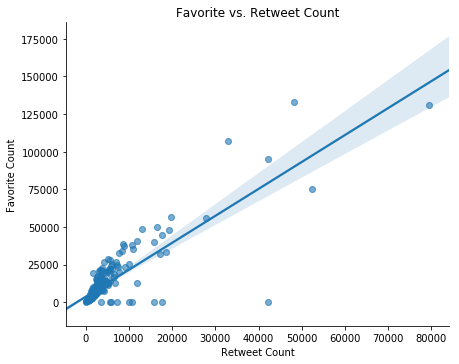

In [100]:
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=df_merge,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5})
plt.title('Favorite vs. Retweet Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

Favorite and retweet counts are highly positively correlated. For about every 4 favorites there is 1 retweet. The majority of the data falls below 40000 favorites and 10000 retweets.

### Retweets, Favorites and Ratings Correlation

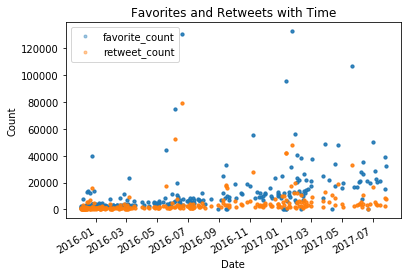

In [95]:
df_merge = pd.read_csv('twitter_archive_master_final.csv')
df_merge['timestamp'] = pd.to_datetime(df_merge['timestamp'])
df_merge.set_index('timestamp', inplace=True)

df_merge[['favorite_count', 'retweet_count']].plot(style = '.', alpha = 0.4)
plt.title('Favorites and Retweets with Time')
plt.xlabel('Date')
plt.ylabel('Count');

Here you can see the gradual increase of both favorites and retweets over time.

### What is the most common dog stage?

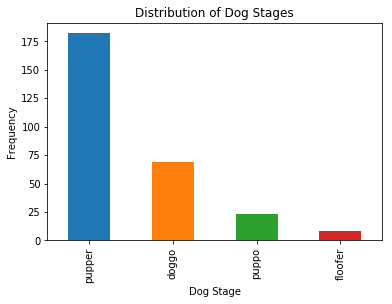

In [96]:
# select the dog_ stage frequencies
df_merge.dog_stage.value_counts().plot('bar')
plt.title("Distribution of Dog Stages")
plt.xlabel('Dog Stage')
plt.ylabel('Frequency');

- As per the dogotionary Pupper is : a small doggo, here Pupper is the most common dog stage in our dataset
- This may be due to dogs at this stage/age prefered by owners.

### Dog Stages Stats

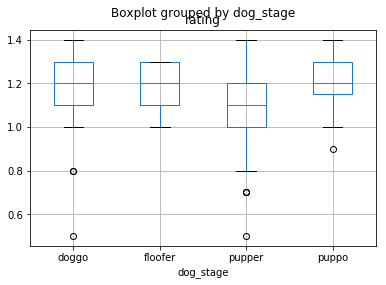

In [97]:
df_merge.boxplot(column='rating', by='dog_stage');

According to the boxplot above, the average rating percent ranking for each dog stage is as follows:

1. floofer
2. puppo
3. doggo
4. pupper



In [98]:
df_merge.groupby('dog_stage')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,69.0,1.188406,0.152948,0.5,1.10,1.2,1.3,1.4
floofer,8.0,1.187500,0.112599,1.0,1.10,1.2,1.3,1.3
pupper,182.0,1.093005,0.147948,0.5,1.00,1.1,1.2,1.4
puppo,23.0,1.200000,0.127920,0.9,1.15,1.2,1.3,1.4


In [99]:
df_merge.reset_index(inplace=True)
df_merge.groupby('dog_stage')['timestamp'].describe()

,count,unique,top,freq,first,last
dog_stage,,,,,,
doggo,69,69,2017-02-23 01:22:14,1,2016-04-02 01:52:38,2017-07-26 15:59:51
floofer,8,8,2016-11-20 17:20:08,1,2016-01-08 03:50:03,2017-07-07 16:22:55
pupper,182,182,2016-01-30 02:41:58,1,2015-12-02 21:06:56,2017-07-15 23:25:31
puppo,23,23,2016-06-20 20:49:19,1,2016-06-03 01:07:16,2017-07-25 01:55:32


So puppers are getting much lower rates than the other dog types. They have several low outliers which decrease the mean to 10.9 as shown in the boxplot.

Floofers are consistently rated above 10. So we can say that floofer are consistently good dogs.



### Insights Summary

- The mean for rating is 1.127;the 3 most common ratings are 1.2,1.0,1.1, and rating frequency becomes smaller as the rating becomes extreme.
- Posts with extreme ratings get more favorites and retweets.Posts with rating 1.4 gets the highest favorite counts and retweet counts.
- Favorites and retweets counts are highly positively correlated. For about every 4 favorites there is 1 retweet. Most of the data falls below 40000 favorites and 10000 retweets
- favorites and retweets are the gradually increase over time
- Among the 4 dog stages, pupper has the biggest frequency, but pupper also gets the lowest favorite counts and retweet counts and rating.

